In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

sns.set()
%matplotlib inline

In [2]:
!ls

 kmeans_model.pkl	 'Telegraph Web Mining.ipynb'   web_app.py
 preprocessing_utils.py   tfidf_pca.pkl		        workpaper
 README.md		  vectorizer.pkl


#### Read the Articles exported files

In [3]:
ny_paper = pd.read_csv('workpaper/nypaper.csv')
foxnews_paper = pd.read_csv('workpaper/foxpaper.csv')
abcnews_paper = pd.read_csv('workpaper/abc_paper.csv')
# cali_paper = pd.read_csv('workpaper/tlp.csv')

In [4]:
ny_paper.head(2)

,url,category,article
0,https://www.nytimes.com/2021/04/05/arts/music/...,arts,The coronavirus pandemic has dealt a devastati...
1,https://www.nytimes.com/2021/04/04/theater/new...,arts,The days are getting longer. The sun is out. T...


In [5]:
foxnews_paper.head(2)

,url,category,article
0,https://www.foxnews.com//politics/hunter-biden...,politics,"In his forthcoming memoir ""Beautiful Things,"" ..."
1,https://www.foxnews.com//politics/supreme-cour...,politics,The on Monday deemed former President 's ap...


In [6]:
abcnews_paper.head(2)

,url,category,article
0,https://abcnews.go.com/Lifestyle/wireStory/spr...,lifestyle,NEW YORK -- Can I still spread the after I’m...
1,https://abcnews.go.com/Politics/google-wins-bi...,politics,In the multi-billion Supreme Court clash betwe...


#### Create a DF with the combined articles

In [7]:
df = pd.concat([ny_paper, foxnews_paper, abcnews_paper])

In [8]:
df

,url,category,article
0,https://www.nytimes.com/2021/04/05/arts/music/...,arts,The coronavirus pandemic has dealt a devastati...
1,https://www.nytimes.com/2021/04/04/theater/new...,arts,The days are getting longer. The sun is out. T...
2,https://www.nytimes.com/2021/04/03/theater/bro...,arts,Three hundred and eighty-seven days after Broa...
3,https://www.nytimes.com/2021/04/05/arts/design...,arts,"A few years back, a ,declared that Marcel Duch..."
4,https://www.nytimes.com/2021/04/02/sports/ncaa...,sports,"SAN ANTONIO — , is back in the , title game fo..."
...,...,...,...
150,https://abcnews.go.com/Politics/americans-us-b...,politics,Secretary of Transportation Pete Buttigieg sai...
151,https://abcnews.go.com/Politics/capitol-fencin...,politics,Congress needs to balance making the Capitol c...
152,https://abcnews.go.com/Politics/week-transcrip...,politics,"ANNOUNCER: ""This Week With George Stephanopoul..."
153,https://abcnews.go.com/Politics/california-gov...,politics,California Gov. Gavin Newsom patiently waited ...


### Data Exploration

#### Drop null rows

In [9]:
df = df.dropna()
df = df.reset_index(drop=True)

In [10]:
df_copy = df.copy()

In [11]:
df_copy.head(2)

,url,category,article
0,https://www.nytimes.com/2021/04/05/arts/music/...,arts,The coronavirus pandemic has dealt a devastati...
1,https://www.nytimes.com/2021/04/04/theater/new...,arts,The days are getting longer. The sun is out. T...


In [12]:
df_copy.isnull().sum()

url         0
category    0
article     0
dtype: int64

#### Distribution table for the articles categories

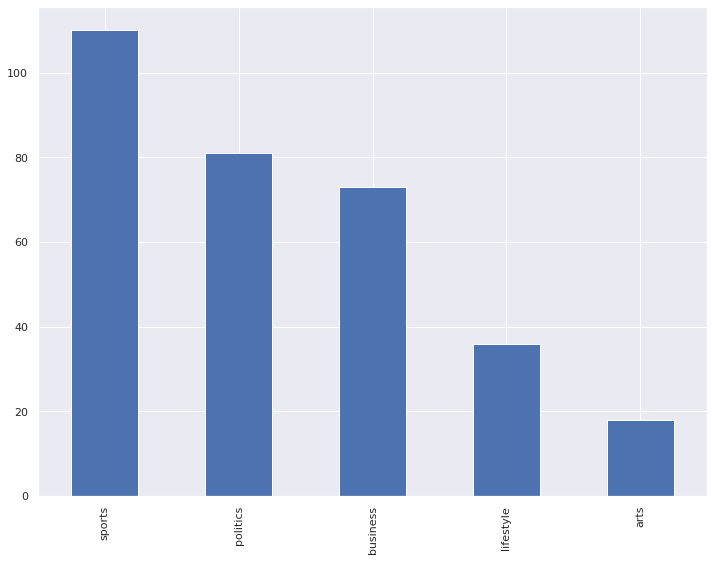

In [13]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
df_copy['category'].value_counts().plot(kind='bar', ax=ax)

#### From the above distribution, it is evident that some categories have different names

#### Combine the categories that have different names on different newspapers
- culture, 
- arts, 
- lifestyle and 
- sport and 
    - sports

In [14]:
combined_cat = ['culture', 'arts', 'lifestyle']
sports = ['sport', 'sports']

df['category'] = df['category'].apply(lambda x: 'Arts/Culture/Celebritie 'if x in combined_cat else('sports' if x in sports else(x)))
df_copy['category'] = df['category'].apply(lambda x: 'Arts/Culture/Celebritie 'if x in combined_cat else('sports' if x in sports else(x)))

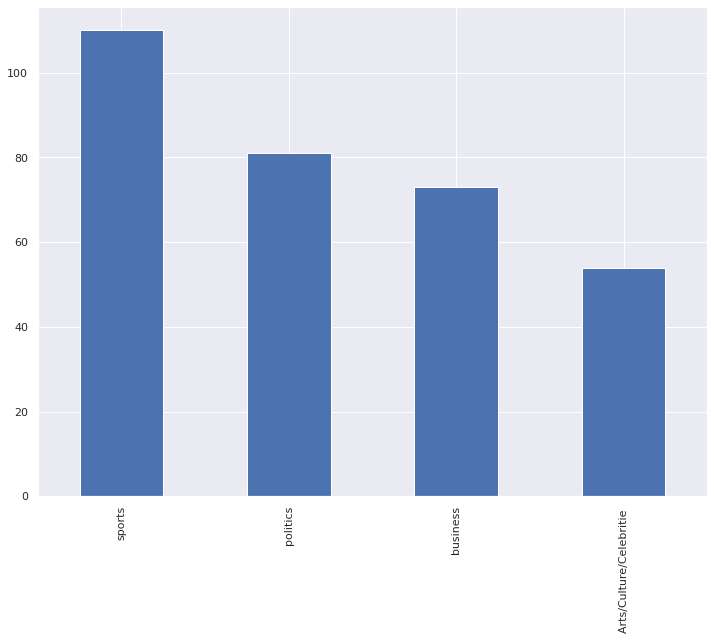

In [15]:
# Look at the distribution of new categories in the articles
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
df_copy['category'].value_counts().plot(kind='bar', ax=ax)

### Data Preprocessing

In [16]:
STOPWORDS = stopwords.words('english')

#### For the contracted words, create a dictionary of their full word

In [17]:
contractions_dict = { 
    "ain't": "are not","'s":" is","aren't": "are not",
     "can't": "cannot","can't've": "cannot have",
     "'cause": "because","could've": "could have","couldn't": "could not",
     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
     "hasn't": "has not","haven't": "have not","he'd": "he would",
     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
     "it'd": "it would","it'd've": "it would have","it'll": "it will",
     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
     "mayn't": "may not","might've": "might have","mightn't": "might not", 
     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
     "mustn't've": "must not have", "needn't": "need not",
     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
     "she'll": "she will", "she'll've": "she will have","should've": "should have",
     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
     "there'd've": "there would have", "they'd": "they would",
     "they'd've": "they would have","they'll": "they will",
     "they'll've": "they will have", "they're": "they are","they've": "they have",
     "to've": "to have","wasn't": "was not","we'd": "we would",
     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
     "what'll've": "what will have","what're": "what are", "what've": "what have",
     "when've": "when have","where'd": "where did", "where've": "where have",
     "who'll": "who will","who'll've": "who will have","who've": "who have",
     "why've": "why have","will've": "will have","won't": "will not",
     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
     "y'all'd've": "you all would have","y'all're": "you all are",
     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
     "you'll": "you will","you'll've": "you will have", "you're": "you are",
     "you've": "you have"
}

#### Remove non ASCII characters from the dataframe
#### Expand the contracted words

In [18]:
def preprocess_article(article):
    res_article = []
    lemmatizer = WordNetLemmatizer()
    
    for word in article.split():        
        word = contractions_dict.get(word.lower(), word)
        if word not in STOPWORDS:
            word = re.sub(r'http\S+', '', word)
            emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
            word = emoji_clean.sub(r'', word)
            word = re.sub(r'[^\w\s]', '', word)
            word = word.lower()
            word = lemmatizer.lemmatize(word, pos='v')
        
            if word != '':
                res_article.append(word)
    return ' '.join([word for word in res_article]) 

#### Apply the preprocessing on the DF copy

In [19]:
df_copy['article'] = df_copy['article'].apply(lambda x: preprocess_article(x))

In [20]:
df.head(2)

,url,category,article
0,https://www.nytimes.com/2021/04/05/arts/music/...,Arts/Culture/Celebritie,The coronavirus pandemic has dealt a devastati...
1,https://www.nytimes.com/2021/04/04/theater/new...,Arts/Culture/Celebritie,The days are getting longer. The sun is out. T...


### Further Data Exploration

In [22]:
article_tokens = [word for article in df_copy['article'] for word in article.split()]
fdist = FreqDist(article_tokens)

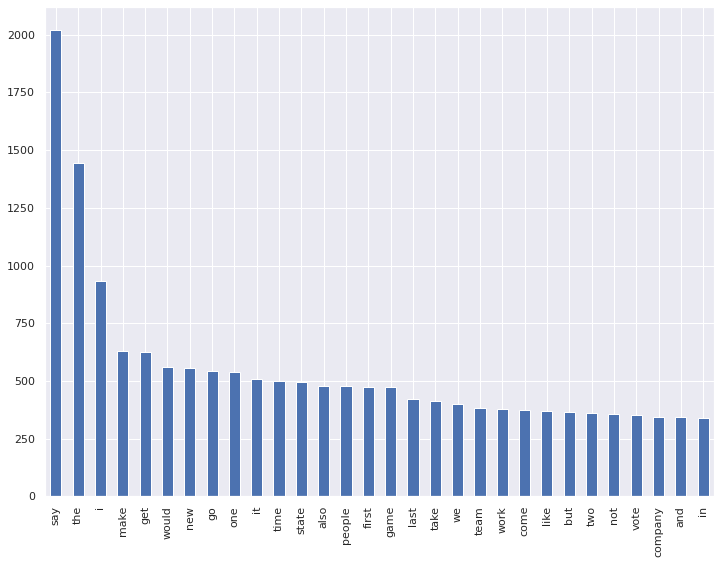

In [23]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()

pd.Series(dict(fdist.most_common(30))).plot(kind='bar', ax=ax)

#### Feature Engineering

#### Vectorization through TFID from Sklearn

In [36]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_article = tfidf_vectorizer.fit_transform(df_copy['article'])

In [37]:
pickle.dump(tfidf_vectorizer, open('vectorizer.pkl', 'wb'))

In [38]:
tfidf_article.toarray().shape

(318, 17026)

In [39]:
tfidf_pca = PCA(n_components = 2) 
tfidf_pca_comp = tfidf_pca.fit_transform(tfidf_article.toarray())

In [40]:
tfidf_pca_comp.shape

(318, 2)

In [41]:
pickle.dump(tfidf_pca, open('tfidf_pca.pkl', 'wb'))

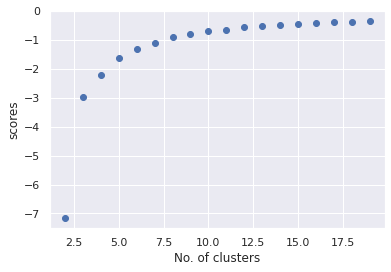

In [42]:
clusters=[]
kmeans_scores=[]

K = range(2, 20)
for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(tfidf_pca_comp)
    kmeans_scores.append(k_means.score(tfidf_pca_comp))
    clusters.append(k)
plt.scatter(clusters,kmeans_scores)
plt.xlabel("No. of clusters")
plt.ylabel("scores")
plt.show()

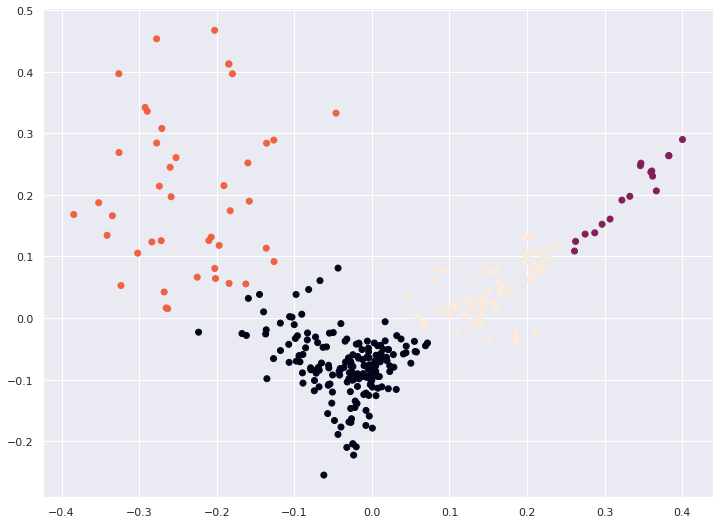

In [50]:
k_means = KMeans(n_clusters=4)
k_means.fit(tfidf_pca_comp)
pred=k_means.predict(tfidf_pca_comp)
plt.figure(figsize=(12,9))
plt.scatter(tfidf_pca_comp[:,0],tfidf_pca_comp[:,1],c=pred)
# sns.scatterplot(x=tfidf_pca_comp[:,0], y=tfidf_pca_comp[:,0], hue=pred)
plt.show()

In [51]:
# Save the kmeans model for deployment
pickle.dump( k_means, open('kmeans_model.pkl', 'wb'))

In [52]:
df['clusters'] = pred
df_copy['clusters'] = pred

df.head()

,url,category,article,clusters
0,https://www.nytimes.com/2021/04/05/arts/music/...,Arts/Culture/Celebritie,The coronavirus pandemic has dealt a devastati...,0
1,https://www.nytimes.com/2021/04/04/theater/new...,Arts/Culture/Celebritie,The days are getting longer. The sun is out. T...,0
2,https://www.nytimes.com/2021/04/03/theater/bro...,Arts/Culture/Celebritie,Three hundred and eighty-seven days after Broa...,0
3,https://www.nytimes.com/2021/04/05/arts/design...,Arts/Culture/Celebritie,"A few years back, a ,declared that Marcel Duch...",0
4,https://www.nytimes.com/2021/04/02/sports/ncaa...,sports,"SAN ANTONIO — , is back in the , title game fo...",1


In [53]:
df_copy['clusters'].unique()

array([0, 1, 2, 3], dtype=int32)

#### Export this Df as a CSV

In [ ]:
# df_copy.to_csv('Articlesclusters.csv')
df_copy.to_csv('Articlesclusters.csv', index=False)

In [104]:
clusterOne = df_copy[df_copy['clusters'] == 0][['category', 'article', 'clusters']]
clusterOnePlot = df_copy[df_copy['clusters'] == 0]['category'].value_counts()

In [109]:
clusterTwo = df_copy[df_copy['clusters'] == 1][['category', 'article', 'clusters']]
clusterTwoPlot = df_copy[df_copy['clusters'] == 1]['category'].value_counts()

In [110]:
clusterThree = df_copy[df_copy['clusters'] == 2][['category', 'article', 'clusters']]
clusterThreePlot = df_copy[df_copy['clusters'] == 2]['category'].value_counts()

In [111]:
clusterFour = df_copy[df_copy['clusters'] == 3][['category', 'article', 'clusters']]
clusterFourPlot = df_copy[df_copy['clusters'] == 3]['category'].value_counts()

In [114]:
clusterOne.head(2)

,category,article,clusters
0,Arts/Culture/Celebritie,the coronavirus pandemic deal devastate blow p...,0
1,Arts/Culture/Celebritie,the days get longer the sun out the number vac...,0


In [115]:
clusterTwo.head(2)

,category,article,clusters
4,sports,san antonio back title game first time since 2...,1
7,sports,from first possession friday night arizonas na...,1


In [117]:
clusterThree.head(2)

,category,article,clusters
8,sports,gov brian kemp georgia saturday issue blister ...,2
21,business,washington senator ron wyden oregon democrat c...,2


In [118]:
clusterFour.head(2)

,category,article,clusters
10,sports,gary sanchez join elston howard 1963 yankees c...,3
14,sports,augusta ga the first augusta national womens a...,3


#### Create Distribution graphs for the four clusters above

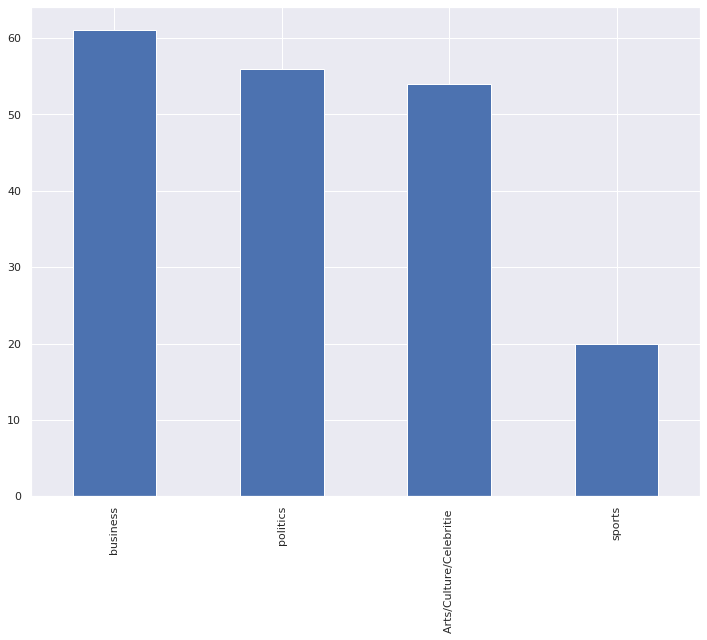

In [112]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
clusterOnePlot.plot(kind='bar', ax=ax)

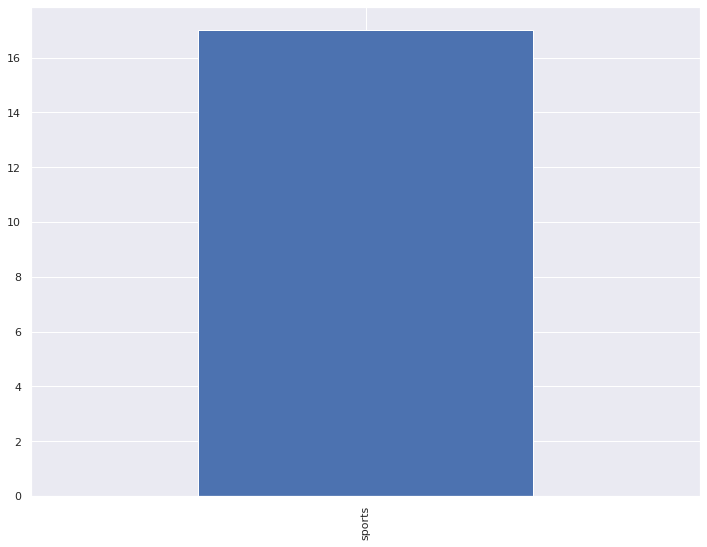

In [119]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
clusterTwoPlot.plot(kind='bar', ax=ax)

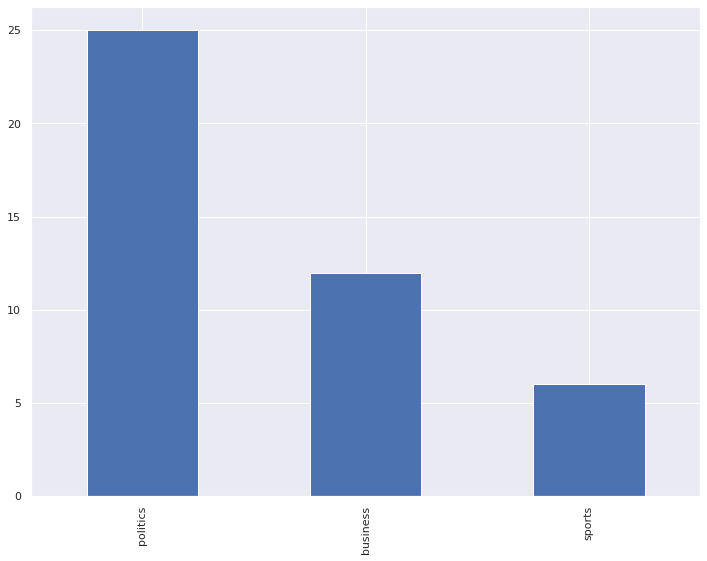

In [120]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
clusterThreePlot.plot(kind='bar', ax=ax)

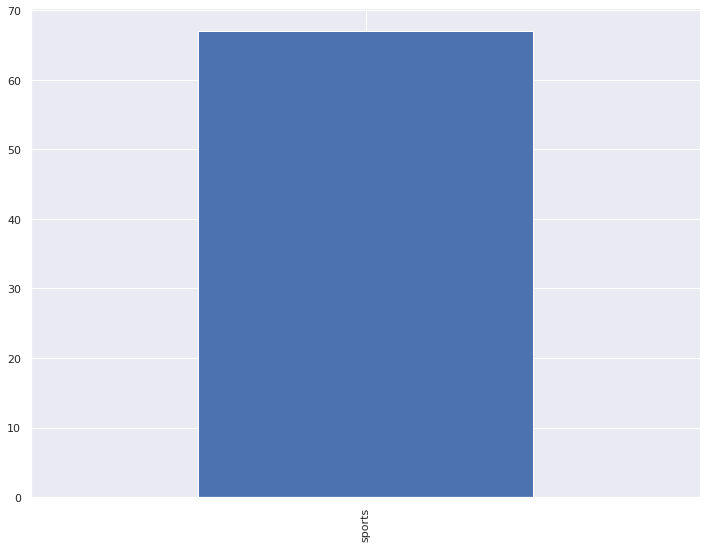

In [121]:
fig = plt.figure(figsize=(12,9))
ax = fig.gca()
clusterFourPlot.plot(kind='bar', ax=ax)